In [4]:
!pip install dill==0.3.3
!pip install multiprocess
!pip install netron>=4.7.9
!pip install brevitas==0.6.0
!pip install onnxoptimizer==0.2.6
!pip install git+https://github.com/Xilinx/finn-base.git@feature/itu_competition_21#egg=finn-base[onnx]
!pip install versioned-hdf5
!pip uninstall -y numpy 
!pip install --upgrade numpy==1.18.0

Found existing installation: tensorflow-gpu 2.4.1
Uninstalling tensorflow-gpu-2.4.1:
ERROR: Exception:
Traceback (most recent call last):
  File "/usr/lib/python3.8/shutil.py", line 788, in move
    os.rename(src, real_dst)
PermissionError: [Errno 13] Permission denied: '/usr/bin/estimator_ckpt_converter' -> '/tmp/pip-uninstall-3m0mn3g3/estimator_ckpt_converter'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/commands/uninstall.py", line 85, in run
    uninstall_pathset = req.uninstall(
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/req/req_install.py", line 653, in uninstall
    uninstalled_pathset.remove(auto_confirm, verbose)
  File "/usr/local/lib/python3.8/dist-packages/pip/_internal/req/req_uninstall.py", line 386

In [ ]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
import brevitas.nn as qnn
from brevitas.quant import IntBias
from brevitas.inject.enum import ScalingImplType
from brevitas.inject.defaults import Int8ActPerTensorFloatMinMaxInit
from torch.utils.data import Dataset, DataLoader
import h5py
from brevitas.export.onnx.generic.manager import BrevitasONNXManager
from finn.util.inference_cost import inference_cost
import json
import os
from torch.utils.data import Dataset, DataLoader
import h5py
import copy
import torch.nn.utils.prune as prune

ERROR! Session/line number was not unique in database. History logging moved to new session 2


In [5]:
gpu = 0
if torch.cuda.is_available():
    torch.cuda.device(gpu)
    print("Using GPU %d" % gpu)
else:
    gpu = None
    print("Using CPU only")

def load_checkpoint(model, savefile):
    saved_state = torch.load(savefile, map_location=torch.device("cpu"))
    model.load_state_dict(saved_state)
    print(f"Model in {savefile} loaded\n")
    logFile.write(f"Model in {savefile} loaded\n")
    if gpu is not None:
        model = model.cuda()
    return model

Using GPU 0
ERROR! Session/line number was not unique in database. History logging moved to new session 3


In [6]:
# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [7]:
# ُSpecify the dataset_path
dataset_path = "/home/ubuntu/5g/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5"

class radioml_18_dataset(Dataset):
    def __init__(self, dataset_path):
        super(radioml_18_dataset, self).__init__()
        h5_file = h5py.File(dataset_path,'r')
        self.data = h5_file['X']
        self.mod = np.argmax(h5_file['Y'], axis=1) # comes in one-hot encoding
        self.snr = h5_file['Z'][:,0]
        self.len = self.data.shape[0]

        self.mod_classes = ['OOK','4ASK','8ASK','BPSK','QPSK','8PSK','16PSK','32PSK',
        '16APSK','32APSK','64APSK','128APSK','16QAM','32QAM','64QAM','128QAM','256QAM',
        'AM-SSB-WC','AM-SSB-SC','AM-DSB-WC','AM-DSB-SC','FM','GMSK','OQPSK']
        self.snr_classes = np.arange(-20., 32., 2) # -20dB to 30dB

        # do not touch this seed to ensure the prescribed train/test split!
        np.random.seed(2018)
        train_indices = []
        test_indices = []
        for mod in range(0, 24): # all modulations (0 to 23)
            for snr_idx in range(0, 26): # all SNRs (0 to 25 = -20dB to +30dB)
                # 'X' holds frames strictly ordered by modulation and SNR
                start_idx = 26*4096*mod + 4096*snr_idx
                indices_subclass = list(range(start_idx, start_idx+4096))
                
                # 90%/10% training/test split, applied evenly for each mod-SNR pair
                split = int(np.ceil(0.1 * 4096)) 
                np.random.shuffle(indices_subclass)
                train_indices_subclass = indices_subclass[split:]
                test_indices_subclass = indices_subclass[:split]
                
                # you could train on a subset of the data, e.g. based on the SNR
                # here we use all available training samples
                if snr_idx >= 0:
                    train_indices.extend(train_indices_subclass)
                test_indices.extend(test_indices_subclass)
                
        self.train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        self.test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

    def __getitem__(self, idx):
        # transpose frame into Pytorch channels-first format (NCL = -1,2,1024)
        return self.data[idx].transpose(), self.mod[idx], self.snr[idx]

    def __len__(self):
        return self.len

dataset = radioml_18_dataset(dataset_path)

In [53]:
model_vgg_path = "/home/ubuntu/pretrained_VGG10_w8a8_20.pth"
model_proposed_path = "/home/ubuntu/main.pth"
model_proposed_pruned = "/home/ubuntu/pruned.pth"
model_best = "/home/ubuntu/high_acc"

In [54]:
# Adjustable hyperparameters
input_bits = 8
a_bits = 8
w_bits = 8
filters_conv = 64
filters_dense = 128

# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

class InputQuantizer(Int8ActPerTensorFloatMinMaxInit):
    bit_width = input_bits
    min_val = -2.0
    max_val = 2.0
    scaling_impl_type = ScalingImplType.CONST # Fix the quantization range to [min_val, max_val]

model_vgg = nn.Sequential(
    # Input quantization layer
    qnn.QuantHardTanh(act_quant=InputQuantizer),

    qnn.QuantConv1d(2, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits,bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),

    qnn.QuantConv1d(filters_conv, filters_conv, 3, padding=1, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_conv),
    qnn.QuantReLU(bit_width=a_bits),
    nn.MaxPool1d(2),
    
    nn.Flatten(),

    qnn.QuantLinear(filters_conv*8, filters_dense, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_dense),
    qnn.QuantReLU(bit_width=a_bits),

    qnn.QuantLinear(filters_dense, filters_dense, weight_bit_width=w_bits, bias=False),
    nn.BatchNorm1d(filters_dense),
    qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True),

    qnn.QuantLinear(filters_dense, 24, weight_bit_width=w_bits, bias=True, bias_quant=IntBias),
)

In [55]:
class MSCLayer(nn.Module):
    def __init__(self, output_filters, w_bits, a_bits, bias=True):
        super(MSCLayer, self).__init__()
        filters_in = 2
        stride = 4
        ksize1 = 32
        padding1 = ksize1 // 2
        filter_num1 = output_filters // 3
        self.branch1 = nn.Sequential(
            qnn.QuantConv1d(filters_in, filter_num1, ksize1, padding=padding1, weight_bit_width=w_bits, bias=bias, stride=stride),
            nn.BatchNorm1d(filter_num1),
            qnn.QuantReLU(bit_width=a_bits),
            qnn.QuantConv1d(filter_num1, filter_num1, 1, stride=1, padding=0, weight_bit_width=w_bits, bias=bias),
            nn.BatchNorm1d(filter_num1)
        )

        ksize2 = 26
        padding2 = ksize2 // 2
        filter_num2 = output_filters // 3

        self.branch2 = nn.Sequential(
            qnn.QuantConv1d(filters_in, filter_num2, ksize2, padding=padding2, weight_bit_width=w_bits, bias=bias, stride=stride),
            nn.BatchNorm1d(filter_num2),
            qnn.QuantReLU(bit_width=a_bits),
            qnn.QuantConv1d(filter_num2, filter_num2, 1, stride=1, padding=0, weight_bit_width=w_bits, bias=bias),
            nn.BatchNorm1d(filter_num2)
        )

        ksize3 = 18
        padding3 = ksize3 // 2
        filter_num3 = output_filters // 3

        self.branch3 = nn.Sequential(
            qnn.QuantConv1d(filters_in, filter_num3, ksize3, padding=padding3, weight_bit_width=w_bits, bias=bias, stride=stride),
            nn.BatchNorm1d(filter_num3),
            qnn.QuantReLU(bit_width=a_bits),
            qnn.QuantConv1d(filter_num3, filter_num3, 1, stride=1, padding=0, weight_bit_width=w_bits, bias=bias),
            nn.BatchNorm1d(filter_num3)
        )

    def _forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)

        outputs = [branch1, branch2, branch3]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)

class AaronBlock(nn.Module):
    def __init__(self, filters_conv_in, filters_conv_out, ksize, padding, w_bits, a_bits, pool_size=2, bias=True):
        super(AaronBlock, self).__init__()
        self.block = nn.Sequential(
          qnn.QuantConv1d(filters_conv_in, filters_conv_in, ksize, padding=padding, groups=filters_conv_in, weight_bit_width=w_bits, bias=bias),
          nn.BatchNorm1d(filters_conv_in),
          qnn.QuantReLU(bit_width=a_bits),
          qnn.QuantConv1d(filters_conv_in, filters_conv_out, 1, stride=1, padding=0, weight_bit_width=w_bits, bias=bias),
          nn.BatchNorm1d(filters_conv_out),
          nn.MaxPool1d(pool_size)
        )
    def forward(self, x):
        x = self.block(x)
        return x

class AaronNet(nn.Module):
    def __init__(self, config, bits):
        super(AaronNet, self).__init__()
        class InputQuantizer(Int8ActPerTensorFloatMinMaxInit):
            bit_width = bits
            min_val = -2.0
            max_val = 2.0
            scaling_impl_type = ScalingImplType.CONST # Fix the quantization range to [min_val, max_val]
        self.input_ = qnn.QuantHardTanh(act_quant=InputQuantizer)
        conf = config["conv_layers"]
        conf0, conf1 = conf[0], conf[1:]
        filters_conv0, ksize0, padding0, w_bits0, a_bits0, pool_size0, bias0 = conf0

        layers = []
        self.expand = MSCLayer(filters_conv0, w_bits0, a_bits0)
        filters_in = filters_conv0
    
        for filters, k, pad, w_bit, a_bit, pool, bias in conf1:
            layers.append(AaronBlock(filters_in, filters, k, pad, w_bit, a_bit, pool, bias))
            filters_in = filters
        self.feats = nn.Sequential(*layers)
        self.pooling = nn.AdaptiveMaxPool1d(1)
        filters_dense, w_bits, a_bits, bias = config["linear_layers"]

        self.classifier = nn.Sequential(
            qnn.QuantLinear(filters_in, filters_dense, weight_bit_width=w_bits, bias=bias),
            nn.BatchNorm1d(filters_dense),
            qnn.QuantReLU(bit_width=a_bits),

            qnn.QuantLinear(filters_dense, filters_dense, weight_bit_width=w_bits, bias=bias),
            nn.BatchNorm1d(filters_dense),
            qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True),

            qnn.QuantLinear(filters_dense, 24, weight_bit_width=w_bits, bias=True, bias_quant=IntBias),
        )
    def forward(self, x):
        x = self.input_(x)
        x = self.expand(x)
        x = self.feats(x)
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def __init__(self, config, bits):
        super(AaronNet, self).__init__()
        
        class InputQuantizer(Int8ActPerTensorFloatMinMaxInit):
            bit_width = bits
            min_val = -2.0
            max_val = 2.0
            scaling_impl_type = ScalingImplType.CONST # Fix the quantization range to [min_val, max_val]

        self.input_ = qnn.QuantHardTanh(act_quant=InputQuantizer)
        conf = config["conv_layers"]
        conf0, conf1 = conf[0], conf[1:]
        filters_conv0, ksize0, padding0, w_bits0, a_bits0, pool_size0, bias0 = conf0

        layers = []
        self.expand = MSCLayer(filters_conv0, w_bits0, a_bits0)
        filters_in = filters_conv0
    
        for filters, k, pad, w_bit, a_bit, pool, bias in conf1:
            layers.append(AaronBlock(filters_in, filters, k, pad, w_bit, a_bit, pool, bias))
            filters_in = filters
        self.feats = nn.Sequential(*layers)
        self.pooling = nn.AdaptiveMaxPool1d(1)
        filters_dense, w_bits, a_bits, bias = config["linear_layers"]

        self.classifier = nn.Sequential(
            qnn.QuantLinear(filters_in, filters_dense, weight_bit_width=w_bits, bias=bias),
            nn.BatchNorm1d(filters_dense),
            qnn.QuantReLU(bit_width=a_bits),

            qnn.QuantLinear(filters_dense, filters_dense, weight_bit_width=w_bits, bias=bias),
            nn.BatchNorm1d(filters_dense),
            qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True),

            qnn.QuantLinear(filters_dense, 24, weight_bit_width=w_bits, bias=True, bias_quant=IntBias),
        )
    def forward(self, x):
        x = self.input_(x)
        x = self.expand(x)
        x = self.feats(x)
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



config = {
    "conv_layers": [
        #filters, ksize, padding, w_bits, a_bits, pool, bias
        [33, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [40, 3, 1, 6, 6, 2, True],
    ],
    "linear_layers": [48, 6, 6, True]
}
# model_vgg = AaronNet(config, 6)
proposed_baseline = AaronNet(config, 6)
proposed_pruned = AaronNet(config, 6)


In [58]:
class MSCLayer(nn.Module):
    def __init__(self, output_filters, w_bits, a_bits, bias=True):
        super(MSCLayer, self).__init__()
        filters_in = 2
        stride = 4
        ksize1 = 32
        padding1 = ksize1 // 2
        filter_num1 = output_filters // 3
        self.branch1 = nn.Sequential(
            qnn.QuantConv1d(filters_in, filter_num1, ksize1, padding=padding1, weight_bit_width=w_bits, bias=bias, stride=stride),
            nn.BatchNorm1d(filter_num1),
            qnn.QuantReLU(bit_width=a_bits),
            qnn.QuantConv1d(filter_num1, filter_num1, 1, stride=1, padding=0, weight_bit_width=w_bits, bias=bias),
            nn.BatchNorm1d(filter_num1)
        )

        ksize2 = 26
        padding2 = ksize2 // 2
        filter_num2 = output_filters // 3

        self.branch2 = nn.Sequential(
            qnn.QuantConv1d(filters_in, filter_num2, ksize2, padding=padding2, weight_bit_width=w_bits, bias=bias, stride=stride),
            nn.BatchNorm1d(filter_num2),
            qnn.QuantReLU(bit_width=a_bits),
            qnn.QuantConv1d(filter_num2, filter_num2, 1, stride=1, padding=0, weight_bit_width=w_bits, bias=bias),
            nn.BatchNorm1d(filter_num2)
        )

        ksize3 = 18
        padding3 = ksize3 // 2
        filter_num3 = output_filters // 3

        self.branch3 = nn.Sequential(
            qnn.QuantConv1d(filters_in, filter_num3, ksize3, padding=padding3, weight_bit_width=w_bits, bias=bias, stride=stride),
            nn.BatchNorm1d(filter_num3),
            qnn.QuantReLU(bit_width=a_bits),
            qnn.QuantConv1d(filter_num3, filter_num3, 1, stride=1, padding=0, weight_bit_width=w_bits, bias=bias),
            nn.BatchNorm1d(filter_num3)
        )

    def _forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)

        outputs = [branch1, branch2, branch3]
        return outputs

    def forward(self, x):
        outputs = self._forward(x)
        return torch.cat(outputs, 1)

class MammadBlock(nn.Module):
    def __init__(self, filters_conv_in, filters_conv_out, ksize, padding, w_bits, a_bits, pool_size=2, bias=True):
        super(MammadBlock, self).__init__()
        self.block = nn.Sequential(
          qnn.QuantConv1d(filters_conv_in, filters_conv_in, ksize, padding=padding, groups=filters_conv_in, weight_bit_width=w_bits, bias=bias),
          nn.BatchNorm1d(filters_conv_in),
          qnn.QuantReLU(bit_width=a_bits),
          qnn.QuantConv1d(filters_conv_in, filters_conv_out, 1, stride=1, padding=0, weight_bit_width=w_bits, bias=bias),
          nn.BatchNorm1d(filters_conv_out),
          nn.MaxPool1d(pool_size)
        )
    def forward(self, x):
        x = self.block(x)
        return x

class AaronNet48(nn.Module):
    def __init__(self, config):
        super(AaronNet48, self).__init__()
        self.input_ = qnn.QuantHardTanh(act_quant=InputQuantizer)
        conf = config["conv_layers"]
        conf0, conf1 = conf[0], conf[1:]
        filters_conv0, ksize0, padding0, w_bits0, a_bits0, pool_size0, bias0 = conf0

        layers = []
        self.expand = MSCLayer(filters_conv0, w_bits0, a_bits0)
        filters_in = filters_conv0
    
        for filters, k, pad, w_bit, a_bit, pool, bias in conf1:
            layers.append(MammadBlock(filters_in, filters, k, pad, w_bit, a_bit, pool, bias))
            filters_in = filters
        self.feats = nn.Sequential(*layers)
        self.pooling = nn.AdaptiveMaxPool1d(1)
        filters_dense, w_bits, a_bits, bias = config["linear_layers"]

        self.classifier = nn.Sequential(
            qnn.QuantLinear(filters_in, filters_dense, weight_bit_width=w_bits, bias=bias),
            nn.BatchNorm1d(filters_dense),
            qnn.QuantReLU(bit_width=a_bits),

            qnn.QuantLinear(filters_dense, filters_dense, weight_bit_width=w_bits, bias=bias),
            nn.BatchNorm1d(filters_dense),
            qnn.QuantReLU(bit_width=a_bits, return_quant_tensor=True),

            qnn.QuantLinear(filters_dense, 24, weight_bit_width=w_bits, bias=True, bias_quant=IntBias),
        )
    def forward(self, x):
        x = self.input_(x)
        x = self.expand(x)
        x = self.feats(x)
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


config = {
    "conv_layers": [
        #filters, ksize, padding, w_bits, a_bits, pool, bias
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
    ],
    "linear_layers": [48, 6, 6, True]
}
proposed_best = AaronNet48(config)

In [59]:
# Load trained parameters
saved_state_vgg = torch.load(model_vgg_path, map_location=torch.device("cpu"))
saved_state_proposed_baseline = torch.load(model_proposed_path, map_location=torch.device("cpu"))
saved_state_proposed_pruned = torch.load(model_proposed_pruned, map_location=torch.device("cpu"))
save_state_best = torch.load(model_best, map_location=torch.device("cpu"))

model_vgg.load_state_dict(saved_state_vgg)
proposed_baseline.load_state_dict(saved_state_proposed_baseline)
proposed_pruned.load_state_dict(saved_state_proposed_pruned)
proposed_best.load_state_dict(save_state_best)

if gpu is not None:
    model_vgg = model_vgg.cuda()
    proposed_baseline = proposed_baseline.cuda()
    proposed_pruned = proposed_pruned.cuda()
    proposed_best = proposed_best.cuda()

In [60]:
# Set up a fresh test data loader
batch_size = 1024
dataset = radioml_18_dataset(dataset_path)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

In [61]:
# Plot overall confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [62]:
# Run inference on validation data
y_exp = np.empty((0))
y_snr = np.empty((0))
# y_exp_vgg = np.empty((0))
# y_exp_proposed_baseline = np.empty((0))
# y_exp_proposed_pruned = np.empty((0))

# y_snr_vgg = np.empty((0))
# y_snr_proposed_baseline = np.empty((0))
# y_snr_proposed_pruned = np.empty((0))

y_pred_vgg = np.empty((0, len(dataset.mod_classes)))
y_pred_proposed_baseline = np.empty((0, len(dataset.mod_classes)))
y_pred_proposed_pruned = np.empty((0, len(dataset.mod_classes)))
y_pred_best = np.empty((0, len(dataset.mod_classes)))

model_vgg.eval()
proposed_baseline.eval()
proposed_pruned.eval()
proposed_best.eval()
with torch.no_grad():
    for data in tqdm(data_loader_test, desc="Batches"):
        inputs, target, snr = data
        if gpu is not None:
            inputs = inputs.cuda()
        output_vgg = model_vgg(inputs)
        output_proposed_baseline = proposed_baseline(inputs)
        output_proposed_pruned = proposed_pruned(inputs)
        output_proposed_best = proposed_best(inputs)
        
        y_pred_vgg = np.concatenate((y_pred_vgg, output_vgg.cpu()))
        y_pred_proposed_baseline = np.concatenate((y_pred_proposed_baseline, output_proposed_baseline.cpu()))
        y_pred_proposed_pruned = np.concatenate((y_pred_proposed_pruned, output_proposed_pruned.cpu()))
        y_pred_best = np.concatenate((y_pred_best, output_proposed_best.cpu()))
        
        y_exp = np.concatenate((y_exp,target))
        y_snr = np.concatenate((y_snr,snr))

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

VGG Accuracy across all SNRs: 0.594669
AaronNet Accuracy across all SNRs: 0.584881
Pruned AaronNet Accuracy across all SNRs: 0.560913
Pruned AaronNet Accuracy across all SNRs: 0.601563


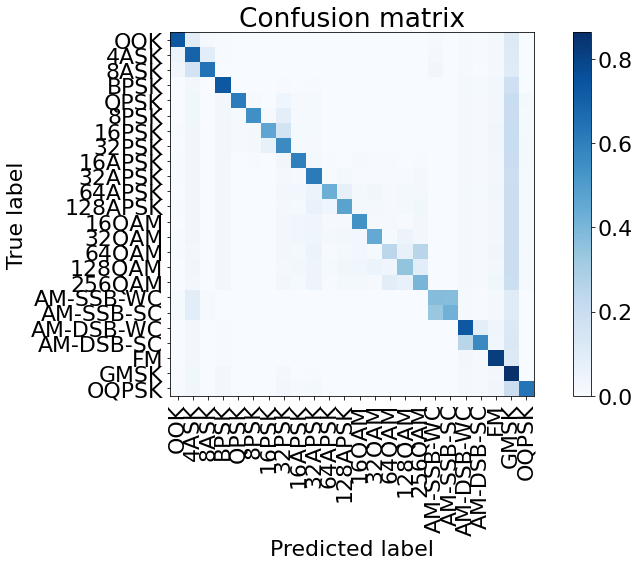

In [63]:
conf_vgg = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
conf_baseline = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
conf_pruned = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
conf_best = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])


confnorm_vgg = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm_baseline = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm_pruned = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
confnorm_best = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])

for i in range(len(y_exp)):
    j = int(y_exp[i])
    k_vgg = int(np.argmax(y_pred_vgg[i,:]))
    k_baseline = int(np.argmax(y_pred_proposed_baseline[i,:]))
    k_pruned = int(np.argmax(y_pred_proposed_pruned[i,:]))
    k_best = int(np.argmax(y_pred_best[i,:]))
    conf_vgg[j,k_vgg] = conf_vgg[j,k_vgg] + 1
    conf_baseline[j,k_baseline] = conf_baseline[j,k_baseline] + 1
    conf_pruned[j,k_pruned] = conf_pruned[j,k_pruned] + 1
    conf_best[j,k_best] = conf_best[j,k_best] + 1
    
for i in range(0,len(dataset.mod_classes)):
    confnorm_vgg[i,:] = conf_vgg[i,:] / np.sum(conf_vgg[i,:])
    confnorm_baseline[i,:] = conf_baseline[i,:] / np.sum(conf_baseline[i,:])
    confnorm_pruned[i,:] = conf_pruned[i,:] / np.sum(conf_pruned[i,:])
    confnorm_best[i,:] = conf_best[i,:] / np.sum(conf_best[i,:])
    

    

plt.figure(figsize=(12,8))
plot_confusion_matrix(confnorm_pruned, labels=dataset.mod_classes)

cor_vgg = np.sum(np.diag(conf_vgg))
ncor_vgg = np.sum(conf_vgg) - cor_vgg
print("VGG Accuracy across all SNRs: %f"%(cor_vgg / (cor_vgg+ncor_vgg)))

cor_baseline = np.sum(np.diag(conf_baseline))
ncor_baseline = np.sum(conf_baseline) - cor_baseline
print("AaronNet Accuracy across all SNRs: %f"%(cor_baseline / (cor_baseline+ncor_baseline)))

cor_pruned = np.sum(np.diag(conf_pruned))
ncor_pruned = np.sum(conf_pruned) - cor_pruned
print("Pruned AaronNet Accuracy across all SNRs: %f"%(cor_pruned / (cor_pruned+ncor_pruned)))

cor_pruned = np.sum(np.diag(conf_best))
ncor_pruned = np.sum(conf_best) - cor_pruned
print("Pruned AaronNet Accuracy across all SNRs: %f"%(cor_pruned / (cor_pruned+ncor_pruned)))

In [17]:
def calculate_cost(model):
    export_onnx_path = "model_export.onnx"
    final_onnx_path = "model_final.onnx"
    cost_dict_path = "model_cost.json"
    BrevitasONNXManager.export(model.cpu(), input_t=torch.randn(1, 2, 1024), export_path=export_onnx_path, opset_version = 9)
    inference_cost(export_onnx_path, output_json=cost_dict_path, output_onnx=final_onnx_path,
                preprocess=True, discount_sparsity=True)

    with open(cost_dict_path, 'r') as f:
        inference_cost_dict = json.load(f)

    bops = int(inference_cost_dict["total_bops"])
    w_bits = int(inference_cost_dict["total_mem_w_bits"])

    bops_baseline = 807699904
    w_bits_baseline = 1244936
    print(f"Ops is {0.5*(bops/bops_baseline)}, w_bits is {0.5*(w_bits/w_bits_baseline)}")
    score = 0.5*(bops/bops_baseline) + 0.5*(w_bits/w_bits_baseline)
    print("Normalized inference cost score: %f" % score)
    return score

In [28]:
# calculate_cost(model_vgg)
# calculate_cost(proposed_baseline)
# proposed_prune(proposed_baseline)

distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-packages
distutils: /usr/local/include/python3.8/UNKNOWN
sysconfig: /usr/include/python3.8
distutils: /usr/local/bin
sysconfig: /usr/bin
distutils: /usr/local
sysconfig: /usr
user = False
home = None
root = None
prefix = None
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 208 kB 15.6 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
distutils: /home/ubuntu/.local/include/python3.8/UNKNOWN
sysconfig: /home/ubuntu/.local/include/python3.8
user = True
home = None
root = None
prefix = None
You should consider upgrading via the '/bin/python3 -m pip install --upgrade pip' command.
distutils: /usr/local/lib/python3.8/dist-packages
sysconfig: /usr/lib/python3.8/site-

NameError: name 'BrevitasONNXManager' is not defined

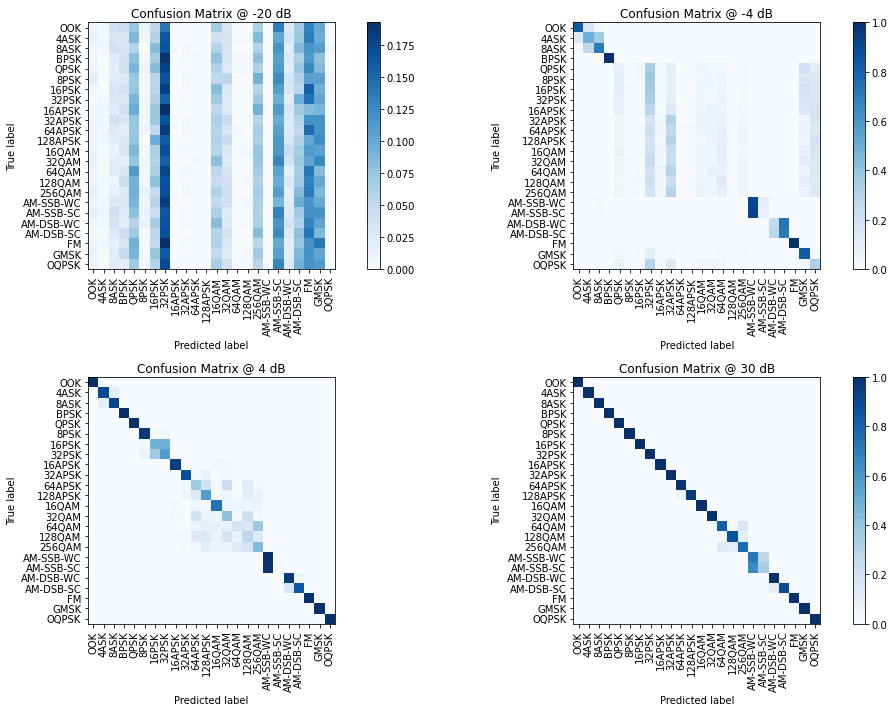

In [32]:
# Plot confusion matrices at 4 different SNRs
snr_to_plot = [-20,-4,+4,+30]
plt.figure(figsize=(16,10))
acc_v = []
for snr in dataset.snr_classes:
    # extract classes @ SNR
    indices_snr = (y_snr == snr).nonzero()
    y_exp_i = y_exp[indices_snr]
    y_pred_i = y_pred_vgg[indices_snr]
 
    conf_v = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm_v = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    for i in range(len(y_exp_i)):
        j = int(y_exp_i[i])
        k = int(np.argmax(y_pred_i[i,:]))
        conf_v[j,k] = conf_v[j,k] + 1
    for i in range(0,len(dataset.mod_classes)):
        confnorm_v[i,:] = conf_v[i,:] / np.sum(conf_v[i,:])
 
    if snr in snr_to_plot:
        plot, = np.where(snr_to_plot == snr)[0]
        plt.subplot(221+plot)
        plot_confusion_matrix(confnorm_v, labels=dataset.mod_classes, title="Confusion Matrix @ %d dB"%(snr))
 
    cor_v = np.sum(np.diag(conf_v))
    ncor_v = np.sum(conf_v) - cor_v
    acc_v.append(cor_v/(cor_v+ncor_v))

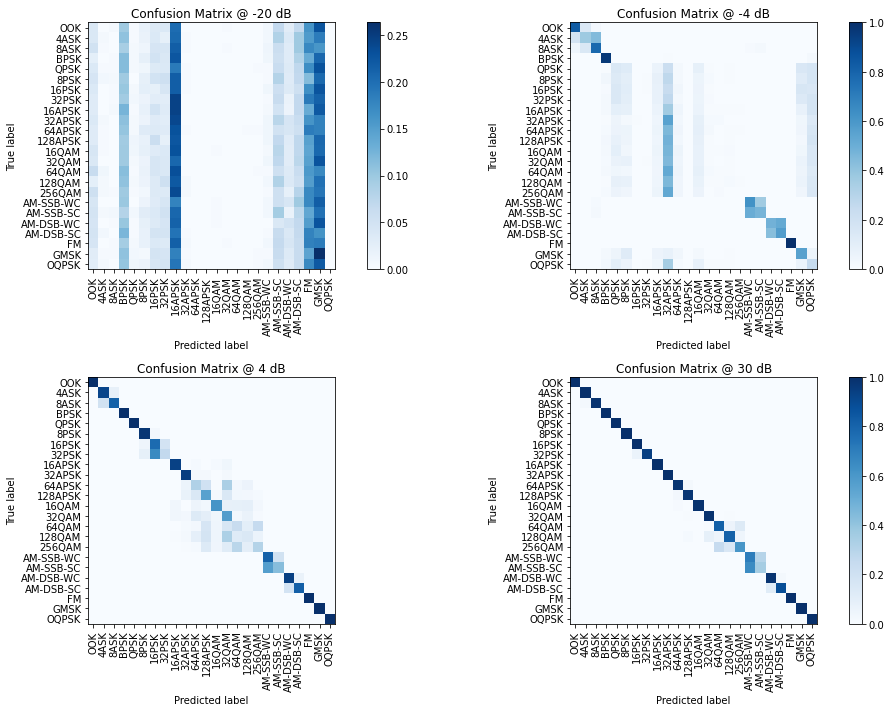

In [35]:
# Plot confusion matrices at 4 different SNRs
snr_to_plot = [-20,-4,+4,+30]
plt.figure(figsize=(16,10))
acc_b = []
for snr in dataset.snr_classes:
    # extract classes @ SNR
    indices_snr = (y_snr == snr).nonzero()
    y_exp_i = y_exp[indices_snr]
    y_pred_i = y_pred_proposed_baseline[indices_snr]
 
    conf_v = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm_v = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    for i in range(len(y_exp_i)):
        j = int(y_exp_i[i])
        k = int(np.argmax(y_pred_i[i,:]))
        conf_v[j,k] = conf_v[j,k] + 1
    for i in range(0,len(dataset.mod_classes)):
        confnorm_v[i,:] = conf_v[i,:] / np.sum(conf_v[i,:])
 
    if snr in snr_to_plot:
        plot, = np.where(snr_to_plot == snr)[0]
        plt.subplot(221+plot)
        plot_confusion_matrix(confnorm_v, labels=dataset.mod_classes, title="Confusion Matrix @ %d dB"%(snr))
 
    cor_v = np.sum(np.diag(conf_v))
    ncor_v = np.sum(conf_v) - cor_v
    acc_b.append(cor_v/(cor_v+ncor_v))

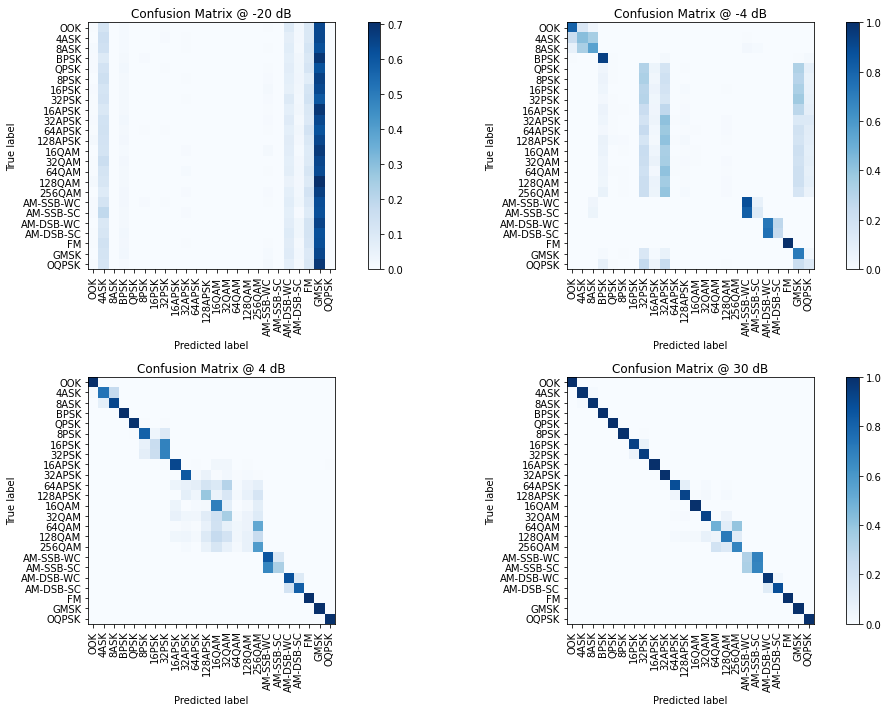

In [37]:
# Plot confusion matrices at 4 different SNRs
snr_to_plot = [-20,-4,+4,+30]
plt.figure(figsize=(16,10))
acc_p = []
for snr in dataset.snr_classes:
    # extract classes @ SNR
    indices_snr = (y_snr == snr).nonzero()
    y_exp_i = y_exp[indices_snr]
    y_pred_i = y_pred_proposed_pruned[indices_snr]
 
    conf_v = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm_v = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    for i in range(len(y_exp_i)):
        j = int(y_exp_i[i])
        k = int(np.argmax(y_pred_i[i,:]))
        conf_v[j,k] = conf_v[j,k] + 1
    for i in range(0,len(dataset.mod_classes)):
        confnorm_v[i,:] = conf_v[i,:] / np.sum(conf_v[i,:])
 
    if snr in snr_to_plot:
        plot, = np.where(snr_to_plot == snr)[0]
        plt.subplot(221+plot)
        plot_confusion_matrix(confnorm_v, labels=dataset.mod_classes, title="Confusion Matrix @ %d dB"%(snr))
 
    cor_v = np.sum(np.diag(conf_v))
    ncor_v = np.sum(conf_v) - cor_v
    acc_p.append(cor_v/(cor_v+ncor_v))

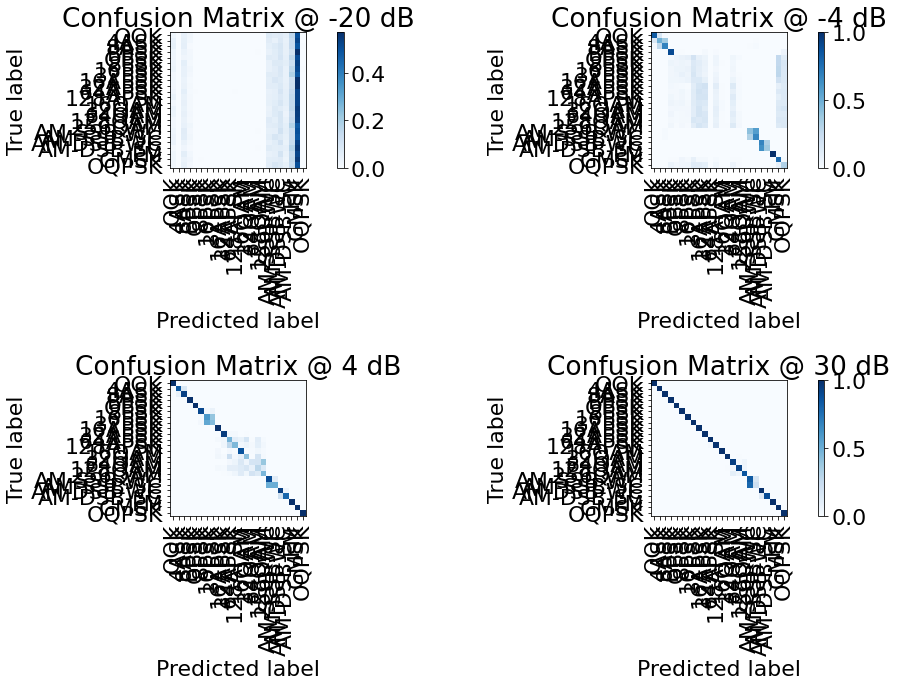

In [64]:
# Plot confusion matrices at 4 different SNRs
snr_to_plot = [-20,-4,+4,+30]
plt.figure(figsize=(16,10))
acc_best = []
for snr in dataset.snr_classes:
    # extract classes @ SNR
    indices_snr = (y_snr == snr).nonzero()
    y_exp_i = y_exp[indices_snr]
    y_pred_i = y_pred_best[indices_snr]
 
    conf_v = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    confnorm_v = np.zeros([len(dataset.mod_classes),len(dataset.mod_classes)])
    for i in range(len(y_exp_i)):
        j = int(y_exp_i[i])
        k = int(np.argmax(y_pred_i[i,:]))
        conf_v[j,k] = conf_v[j,k] + 1
    for i in range(0,len(dataset.mod_classes)):
        confnorm_v[i,:] = conf_v[i,:] / np.sum(conf_v[i,:])
 
    if snr in snr_to_plot:
        plot, = np.where(snr_to_plot == snr)[0]
        plt.subplot(221+plot)
        plot_confusion_matrix(confnorm_v, labels=dataset.mod_classes, title="Confusion Matrix @ %d dB"%(snr))
 
    cor_v = np.sum(np.diag(conf_v))
    ncor_v = np.sum(conf_v) - cor_v
    acc_best.append(cor_v/(cor_v+ncor_v))

Accuracy @ highest SNR (+30 dB): 0.930691
Accuracy overall: 0.594669


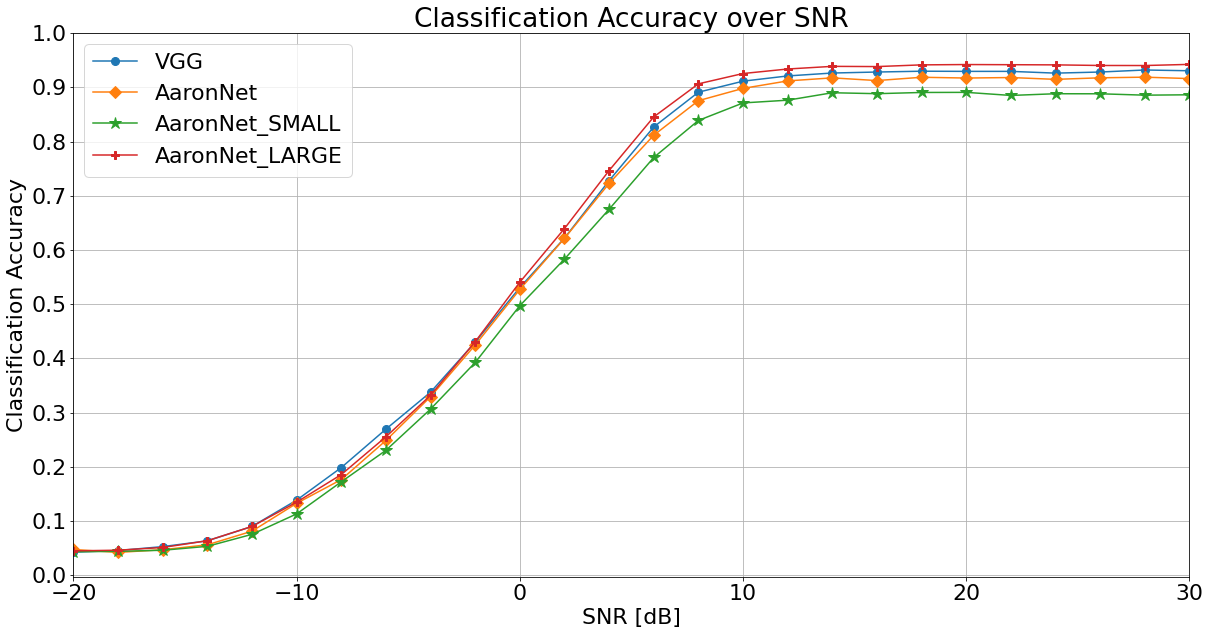

In [80]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
# Plot accuracy over SNR
plt.figure(figsize=(20,10))
plt.plot(dataset.snr_classes, acc, marker='o', markersize=8)
plt.plot(dataset.snr_classes, acc_b, marker='D', markersize=8)
plt.plot(dataset.snr_classes, acc_p, marker='*', markersize=12)
plt.plot(dataset.snr_classes, acc_best, marker='P', markersize=8)
plt.legend(['VGG', 'AaronNet', 'AaronNet_SMALL','AaronNet_LARGE'])
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR")


print("Accuracy @ highest SNR (+30 dB): %f"%(acc[-1]))
print("Accuracy overall: %f"%(np.mean(acc)))